In [1]:
using Pkg
Pkg.activate("..")

  Activating project at `~/code/PhasorNetworks.jl`


In [2]:
include("../src/PhasorNetworks.jl")
using .PhasorNetworks, Plots, DifferentialEquations

[ Info: Precompiling ArrayInterfaceCUDAExt [f78586ac-ba87-5ec7-b3a5-84bc1b258ee3] (cache misses: wrong dep version loaded (2), mismatched flags (2))
[ Info: Precompiling DiffEqBaseCUDAExt [78064ecb-8a7e-51fd-a998-f0197ddca326] (cache misses: wrong dep version loaded (2), mismatched flags (2))
[ Info: Precompiling LinearSolveCUDAExt [e24d4dde-ed20-5ee7-b465-f1dd73f9b6ba] (cache misses: wrong dep version loaded (2), mismatched flags (2))
[ Info: Precompiling NNlibCUDAExt [8a688d86-d2bc-5ad3-8ed1-384f9f2c8cc5] (cache misses: wrong dep version loaded (2), mismatched flags (2))
[ Info: Precompiling MLDataDevicesCUDAExt [75b8c125-561c-596e-9db0-c79879254aa3] (cache misses: wrong dep version loaded (2), mismatched flags (2))
[ Info: Precompiling LuxLibCUDAExt [f6798098-0067-58d1-80b5-15a96058e4b7] (cache misses: wrong dep version loaded (2), mismatched flags (2))
[ Info: Precompiling SpecialFunctionsExt [1285c0f1-ff9f-5867-b66e-0f359bcf09ba] (cache misses: wrong dep version loaded (2), mismat

In [3]:
using Lux, MLUtils, MLDatasets, OneHotArrays, Statistics, Test, LuxCUDA
using Random: Xoshiro, AbstractRNG
using Base: @kwdef
using Zygote: withgradient
using Optimisers, ComponentArrays
using Statistics: mean
using LinearAlgebra: diag
using PhasorNetworks: bind
using Distributions: Normal
using DifferentialEquations: Heun, Tsit5

[ Info: Precompiling NNlibCUDACUDNNExt [ab3ce674-22af-5de9-b6c7-795b17302dcb] (cache misses: wrong dep version loaded (2), mismatched flags (2))
[ Info: Precompiling MLDataDevicescuDNNExt [c8467b85-045e-5d5f-9428-2664c52fe3a2] (cache misses: wrong dep version loaded (2), mismatched flags (2))
[ Info: Precompiling LuxLibcuDNNExt [8424863a-193c-5e57-94b2-cfdf20be1923] (cache misses: wrong dep version loaded (2), mismatched flags (2))
[ Info: Precompiling PhasorNetworks [c32d742c-e486-48f1-8804-9f6fb4d3f42c] (cache misses: wrong dep version loaded (2), mismatched flags (2))


In [4]:
solver_args = Dict(:adaptive => false, :dt => 0.01)

Dict{Symbol, Real} with 2 entries:
  :adaptive => false
  :dt       => 0.01

In [5]:
spk_args = SpikingArgs(threshold = 0.001,
                    solver=Tsit5(), 
                    solver_args = solver_args)

Neuron parameters: Period 1.0 (s)
Current kernel duration: 0.01 (s)
Threshold: 0.001 (V)


In [6]:
cdev = cpu_device()
gdev = gpu_device()

(::CUDADevice{Nothing}) (generic function with 1 method)

In [7]:
#global args for all tests
n_x = 101
n_y = 101
n_vsa = 1
epsilon = 0.10
repeats = 10
epsilon = 0.025


tspan = (0.0, repeats*1.0)
tbase = collect(tspan[1]:spk_args.solver_args[:dt]:tspan[2])

@kwdef mutable struct Args
    η::Float64 = 3e-4       ## learning rate
    batchsize::Int = 256    ## batch size
    epochs::Int = 10        ## number of epochs
    use_cuda::Bool = false   ## use gpu (if cuda available)
    rng::Xoshiro = Xoshiro(42) ## global rng
end

Args

In [8]:
include("../test/network_tests.jl")

spiking_accuracy_test (generic function with 1 method)

In [9]:
import .PhasorNetworks: v_bundle_project, neuron_constant, spike_current, bias_current, gaussian_kernel, is_active

In [10]:
args = Args(use_cuda = true)

Args(0.0003, 256, 10, true, Xoshiro(0xa379de7eeeb2a4e8, 0x953dccb6b532b3af, 0xf597b8ff8cfd652a, 0xccd7337c571680d1, 0xc90c4a0730db3f7e))

In [11]:
model = Chain(Dense(1=>20, relu), Dense(20=>1))
ps, st = Lux.setup(Xoshiro(42), model) .|> gdev
x = rand(Float32, 1, 50) |> gdev
y = model(x, ps, st)  # Check for errors here

(Float32[-0.38932255 -0.39143032 … -0.31698728 -0.29866397], (layer_1 = NamedTuple(), layer_2 = NamedTuple()))

In [12]:
train_loader, test_loader = getdata(args)
x, y = first(train_loader)

(Float32[0.43635908 -0.02072694 … -0.014802111 -0.0019893101; -0.17784306 0.30380124 … -0.07276908 -0.0056274263], Bool[0 0 … 1 1; 1 1 … 0 0])

In [ ]:
#test that norm layers are working
model = Chain(BatchNorm(2), Dense(2=>20, relu),  Dense(20=>10),)
ps, st = Lux.setup(Xoshiro(42), model) .|> gdev

((layer_1 = (scale = Float32[1.0, 1.0], bias = Float32[0.0, 0.0]), layer_2 = (weight = Float32[-0.22298728 0.46045378; -1.5991516 0.21926863; … ; -0.8419455 0.6898169; -1.9868723 -2.060835], bias = Float32[0.11489113, 0.6639945, -0.4025346, -0.6888659, -0.4826754, 0.3613354, 0.48929778, -0.21674016, -0.0905359, -0.19842264, -0.70039135, -0.3391459, 0.69077945, 0.6395895, -0.14078076, -0.61794806, 0.6431609, -0.4320272, -0.5562653, 0.6559268]), layer_3 = (weight = Float32[-0.36478028 -0.35009816 … 0.16633585 -0.09001794; 0.11778823 0.23967978 … 0.16875134 0.2501211; … ; 0.18630779 0.37657124 … -0.22133704 0.3819737; -0.28481823 -0.016084503 … 0.33211577 -0.015221041], bias = Float32[-0.08397981, -0.14111775, 0.0053543923, 0.13371398, -0.19779338, -0.114208594, 0.19246913, -0.20375684, -0.072584175, 0.020619141])), (layer_1 = (running_mean = Float32[0.0, 0.0], running_var = Float32[1.0, 1.0], training = Val{true}()), layer_2 = NamedTuple(), layer_3 = NamedTuple()))

In [ ]:
model(x, ps, st)

(Float32[-1.6251575 -1.3643706 … -1.0334208 -0.8540355; -1.4790964 -0.66562456 … 0.3910789 0.16788703; … ; 0.36006203 0.19507381 … 1.1235024 0.82358015; -0.7144655 -0.43026197 … 0.4476107 0.1147916], (layer_1 = (running_mean = Float32[0.0017730048, 0.00067927514], running_var = Float32[0.9039085, 0.90418065], training = Val{true}()), layer_2 = NamedTuple(), layer_3 = NamedTuple()))

# Test FP32

In [25]:
function build_mlp(args)
    phasor_model = Chain(LayerNorm((2,)), x -> tanh.(x), x -> x, PhasorDense(2 => 128), PhasorDense(128 => 2))
    ps, st = Lux.setup(args.rng, phasor_model)
    return phasor_model, ps, st
end

build_mlp (generic function with 1 method)

In [26]:
x = x |> gdev

2×256 CuArray{Float32, 2, CUDA.DeviceMemory}:
  0.436359  -0.0207269   0.0444016  -0.0051785   …  -0.0148021  -0.00198931
 -0.177843   0.303801   -0.0365956  -0.00554021     -0.0727691  -0.00562743

In [27]:
size(x)

(2, 256)

In [28]:
model_f, ps_f, st_f = build_mlp(args)

(Chain{@NamedTuple{layer_1::LayerNorm{Tuple{Int64}, typeof(identity), Float32, typeof(zeros32), typeof(ones32), Colon, Static.True}, layer_2::WrappedFunction{var"#33#35"}, layer_3::WrappedFunction{var"#34#36"}, layer_4::PhasorDense, layer_5::PhasorDense}, Nothing}((layer_1 = LayerNorm((2,), affine=true, dims=Colon()), layer_2 = WrappedFunction(#33), layer_3 = WrappedFunction(#34), layer_4 = PhasorDense((2, 128)), layer_5 = PhasorDense((128, 2))), nothing), (layer_1 = (bias = Float32[0.0; 0.0;;], scale = Float32[1.0; 1.0;;]), layer_2 = NamedTuple(), layer_3 = NamedTuple(), layer_4 = (weight = Float32[0.025199654 0.005086061; 0.021546587 -0.11127125; … ; 0.15865159 -0.030458387; -0.24032864 0.049523916], bias_real = Float32[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0  …  1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], bias_imag = Float32[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]), layer_5 = (weight = Float32[0.12666641 

In [29]:
ps_f = ps_f |> gdev
st_f = st_f |> gdev

(layer_1 = NamedTuple(), layer_2 = NamedTuple(), layer_3 = NamedTuple(), layer_4 = NamedTuple(), layer_5 = NamedTuple())

In [30]:
tanh.(x)

2×256 CuArray{Float32, 2, CUDA.DeviceMemory}:
  0.410622  -0.020724   0.0443725  -0.00517846  …  -0.014801   -0.00198931
 -0.175992   0.294787  -0.0365793  -0.00554016     -0.0726409  -0.00562737

In [31]:
y_f, _ = model_f(x, ps_f, st_f) 

(Float32[-0.020149658 0.045700043 … 0.014530507 0.011981527; -0.02249537 -0.00995539 … -0.054838575 -0.023126202], (layer_1 = NamedTuple(), layer_2 = NamedTuple(), layer_3 = NamedTuple(), layer_4 = NamedTuple(), layer_5 = NamedTuple()))

In [32]:
y_f |> typeof

CuArray{Float32, 2, CUDA.DeviceMemory}

In [33]:
function build_spiking_mlp(args, spk_args)
    spk_model = Chain(LayerNorm((2,)), x -> tanh.(x), MakeSpiking(spk_args, repeats), PhasorDense(2 => 128), PhasorDense(128 => 2))
    ps, st = Lux.setup(args.rng, spk_model)
    return spk_model, ps, st
end

build_spiking_mlp (generic function with 1 method)

In [34]:
spk_model_f, _, _ = build_spiking_mlp(args, spk_args)

(Chain{@NamedTuple{layer_1::LayerNorm{Tuple{Int64}, typeof(identity), Float32, typeof(zeros32), typeof(ones32), Colon, Static.True}, layer_2::WrappedFunction{var"#37#38"}, layer_3::MakeSpiking, layer_4::PhasorDense, layer_5::PhasorDense}, Nothing}((layer_1 = LayerNorm((2,), affine=true, dims=Colon()), layer_2 = WrappedFunction(#37), layer_3 = MakeSpiking(Neuron parameters: Period 1.0 (s)
Current kernel duration: 0.01 (s)
Threshold: 0.001 (V)
, 10, (0.0, 10.0f0), 0.0), layer_4 = PhasorDense((2, 128)), layer_5 = PhasorDense((128, 2))), nothing), (layer_1 = (bias = Float32[0.0; 0.0;;], scale = Float32[1.0; 1.0;;]), layer_2 = NamedTuple(), layer_3 = NamedTuple(), layer_4 = (weight = Float32[0.27116936 0.0861502; -0.07204794 -0.15312071; … ; -0.039547402 -0.030699156; 0.003936669 -0.020530548], bias_real = Float32[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0  …  1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], bias_imag = Float32[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.

In [36]:
import .PhasorNetworks: phase_to_train

In [37]:
ts = phase_to_time(x, spk_args=spk_args, offset=0.0f0)

2×256 CuArray{Float32, 2, CUDA.DeviceMemory}:
 0.71818   0.489637  0.522201  0.497411  …  0.503094  0.492599  0.499005
 0.411078  0.651901  0.481702  0.49723      0.498118  0.463615  0.497186

In [38]:
import .PhasorNetworks: phase_to_train

In [40]:
a = phase_to_train(x, spk_args=spk_args, repeats=10, offset=0.0f0)

SpikeTrainGPU(CartesianIndex{2}[CartesianIndex(1, 1), CartesianIndex(2, 1), CartesianIndex(1, 2), CartesianIndex(2, 2), CartesianIndex(1, 3), CartesianIndex(2, 3), CartesianIndex(1, 4), CartesianIndex(2, 4), CartesianIndex(1, 5), CartesianIndex(2, 5)  …  CartesianIndex(1, 252), CartesianIndex(2, 252), CartesianIndex(1, 253), CartesianIndex(2, 253), CartesianIndex(1, 254), CartesianIndex(2, 254), CartesianIndex(1, 255), CartesianIndex(2, 255), CartesianIndex(1, 256), CartesianIndex(2, 256)], [1, 2, 3, 4, 5, 6, 7, 8, 9, 10  …  503, 504, 505, 506, 507, 508, 509, 510, 511, 512], Float32[0.7181795, 0.41107845, 0.48963654, 0.65190065, 0.5222008, 0.48170218, 0.49741074, 0.4972299, 0.46343565, 0.50226045  …  9.315895, 9.582314, 9.510534, 9.509322, 9.503094, 9.498118, 9.492599, 9.463615, 9.499005, 9.497187], (2, 256), 512, 0.0f0)

In [43]:
y_spk_f = spk_model_f(x, ps_f, st_f)

LoadError: InvalidIRError: compiling MethodInstance for (::GPUArrays.var"#gpu_broadcast_kernel_linear#38")(::KernelAbstractions.CompilerMetadata{KernelAbstractions.NDIteration.DynamicSize, KernelAbstractions.NDIteration.DynamicCheck, Nothing, CartesianIndices{1, Tuple{Base.OneTo{Int64}}}, KernelAbstractions.NDIteration.NDRange{1, KernelAbstractions.NDIteration.DynamicSize, KernelAbstractions.NDIteration.DynamicSize, CartesianIndices{1, Tuple{Base.OneTo{Int64}}}, CartesianIndices{1, Tuple{Base.OneTo{Int64}}}}}, ::CuDeviceVector{GPUArrays.BrokenBroadcast{Union{}}, 1}, ::Base.Broadcast.Broadcasted{CUDA.CuArrayStyle{1, CUDA.DeviceMemory}, Tuple{Base.OneTo{Int64}}, typeof(*), Tuple{Base.Broadcast.Extruded{CuDeviceVector{Float32, 1}, Tuple{Bool}, Tuple{Int64}}, Base.Broadcast.Broadcasted{CUDA.CuArrayStyle{1, CUDA.DeviceMemory}, Nothing, typeof(Main.PhasorNetworks.gaussian_kernel_gpu), Tuple{Float64, Base.Broadcast.Extruded{CuDeviceVector{Float32, 1}, Tuple{Bool}, Tuple{Int64}}, Float32}}}}) resulted in invalid LLVM IR
[31mReason: unsupported dynamic function invocation[39m[31m (call to gaussian_kernel_gpu)[39m
Stacktrace:
 [1] [0m[1m_broadcast_getindex_evalf[22m
[90m   @[39m [90m./[39m[90m[4mbroadcast.jl:678[24m[39m
 [2] [0m[1m_broadcast_getindex[22m
[90m   @[39m [90m./[39m[90m[4mbroadcast.jl:651[24m[39m
 [3] [0m[1m_getindex[22m
[90m   @[39m [90m./[39m[90m[4mbroadcast.jl:675[24m[39m
 [4] [0m[1m_getindex[22m
[90m   @[39m [90m./[39m[90m[4mbroadcast.jl:674[24m[39m
 [5] [0m[1m_broadcast_getindex[22m
[90m   @[39m [90m./[39m[90m[4mbroadcast.jl:650[24m[39m
 [6] [0m[1mgetindex[22m
[90m   @[39m [90m./[39m[90m[4mbroadcast.jl:610[24m[39m
 [7] [0m[1mgpu_broadcast_kernel_linear[22m
[90m   @[39m [90m~/.julia/packages/KernelAbstractions/sWSE0/src/[39m[90m[4mmacros.jl:322[24m[39m
 [8] [0m[1mgpu_broadcast_kernel_linear[22m
[90m   @[39m [90m./[39m[90m[4mnone:0[24m[39m
[36m[1mHint[22m[39m[36m: catch this exception as `err` and call `code_typed(err; interactive = true)` to introspect the erronous code with Cthulhu.jl[39m

In [41]:
y_spk_f.train.offset

LoadError: UndefVarError: `y_spk_f` not defined in `Main`
Suggestion: check for spelling errors or missing imports.

In [17]:
p_spk_f = train_to_phase(y_spk_f);

In [18]:
size(p_spk_f)

(10, 2, 256)

In [19]:
size(y_f)

(2, 256)

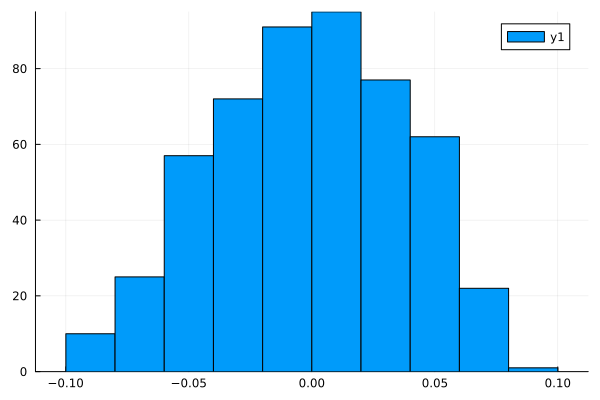

In [20]:
histogram(vec(p_spk_f[5,:,:]))

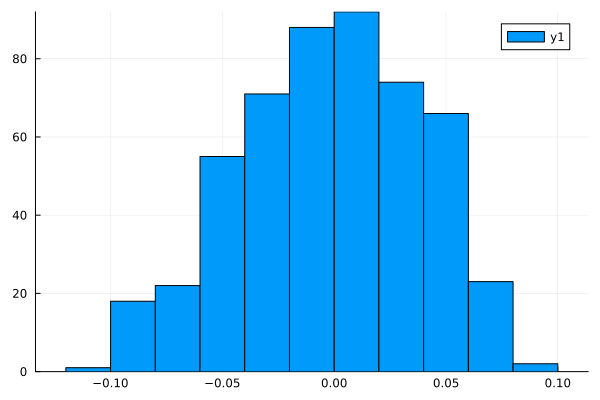

In [21]:
histogram(vec(p_spk_f[6,:,:]))

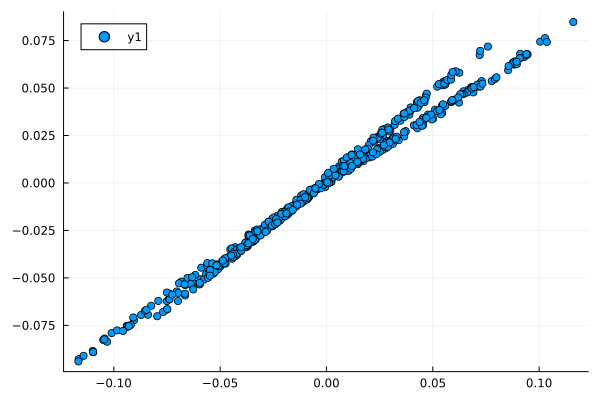

In [22]:
scatter(vec(y_f), vec(p_spk_f[5,:,:]))

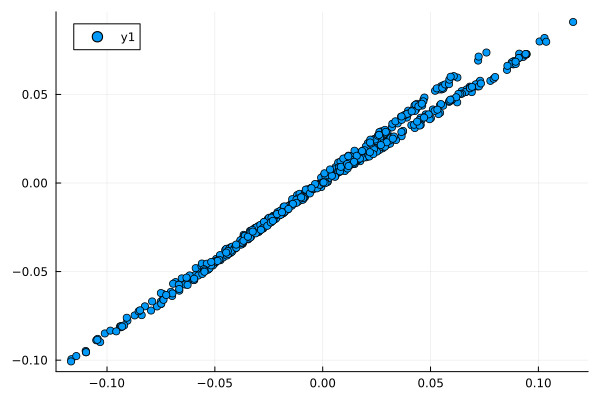

In [23]:
scatter(vec(y_f), vec(p_spk_f[6,:,:]))

In [24]:
cycle_correlation(y_f, p_spk_f)

10-element Vector{Float64}:
 NaN
   0.9574926180865236
   0.9827656087091672
   0.9911054153162355
   0.9945394086500386
   0.9961571724700357
   0.9969892714369741
   0.9974438152049062
   0.9977029173522644
   0.9883285067094865

In [59]:
yg = gdev(1.0 .* y)

2×256 CuArray{Float32, 2, CUDA.DeviceMemory}:
 0.0  0.0  1.0  1.0  1.0  1.0  0.0  0.0  …  0.0  0.0  0.0  1.0  1.0  1.0  1.0
 1.0  1.0  0.0  0.0  0.0  0.0  1.0  1.0     1.0  1.0  1.0  0.0  0.0  0.0  0.0

In [60]:
withgradient(p -> mean(quadrature_loss(model_f(y_f, p, st_f)[1], yg)), ps_f)

(val = 0.5197341842445494, grad = ((layer_1 = (bias = Float32[0.018117957; -0.020602804;;], scale = Float32[-0.017957643; -0.0020068055;;]), layer_2 = nothing, layer_3 = nothing, layer_4 = (weight = Float32[-0.01834086 0.015159973; 0.017222654 -0.013476359; … ; 0.018558076 -0.013557179; 0.017001793 -0.015946168], bias_real = Float32[0.00038507907, -0.0018706203, -0.00071976095, 0.00043746212, 0.00025352946, 0.0032612192, -0.000534084, -0.0071662692, 8.699825f-5, 0.0069288667  …  -0.00096183474, -0.002629008, 6.8552654f-5, -2.4533834f-5, 0.00021212356, -0.0020752111, 0.0023106334, -0.0006772941, -0.0033571986, 0.004875735], bias_imag = Float32[-0.061246473, 0.07366018, 0.06333535, -0.037993208, -0.008010954, -0.081434324, 0.041137412, -0.124384336, -0.091257244, -0.116126776  …  0.0732505, 0.043791085, 0.020983513, -0.09160513, -0.037624672, -0.08140227, 0.107840516, -0.047279563, 0.06795286, 0.053306274]), layer_5 = (weight = Float32[-0.05679664 -0.0696491 … -0.08082472 -0.014223353; -

In [61]:
a, g = withgradient(p -> loss(x, yg, model_f, p, st_f), ps_f)

(val = (0.4987212113809998, (layer_1 = NamedTuple(), layer_2 = NamedTuple(), layer_3 = NamedTuple(), layer_4 = NamedTuple(), layer_5 = NamedTuple())), grad = ((layer_1 = (bias = Float32[0.17176123; -0.040392205;;], scale = Float32[-0.008648398; 0.0021712126;;]), layer_2 = nothing, layer_3 = nothing, layer_4 = (weight = Float32[0.0015298042 0.011307665; -0.0043987567 -0.012548527; … ; -0.0006506896 -0.009107366; -0.005099245 -0.016322998], bias_real = Float32[-9.606203f-5, -0.0013015124, -0.0008788124, -0.0002187569, 0.000110472785, 0.00023189893, -0.0006497991, 0.0028312895, 0.00012291546, 0.0031987  …  -0.003252416, -0.0026080452, -7.268146f-5, -0.000443843, 0.0001655867, -0.0005336731, -0.00018988618, -0.00045479074, -0.00017416284, -0.000417116], bias_imag = Float32[-0.060389806, 0.07913968, 0.06782135, -0.03510412, -0.010934737, -0.07724918, 0.045660228, -0.16075012, -0.09438431, -0.12403314  …  0.09014808, 0.055486888, 0.022326846, -0.09302248, -0.039136708, -0.08501748, 0.1177175

In [65]:
losses_f, ps_train_f, st_train_f = train(model_f, ps_f, st_f, train_loader, args)

[ Info: Training on CUDA GPU


(Any[0.4987212113809998, 0.521122191794009, 0.5082742479009222, 0.5136231814811849, 0.49438453474908484, 0.4974023651358642, 0.4872463278624626, 0.4812212228282078, 0.48914629215988037, 0.48157892148610654  …  0.05532420755450476, 0.043126595831990286, 0.043077381269434736, 0.04251557404212223, 0.059209086565330415, 0.04838971455472543, 0.05391948963310008, 0.05201482573252102, 0.0604854485165138, 0.04945148768182123], (layer_1 = (bias = Float32[-0.19326492; -0.1934431;;], scale = Float32[0.8069064; 0.7923898;;]), layer_2 = NamedTuple(), layer_3 = NamedTuple(), layer_4 = (weight = Float32[0.041125026 0.010296932; 0.0069805593 -0.09867007; … ; 0.15147264 -0.017196883; -0.24489555 0.021723168], bias_real = Float32[0.98994374, 1.0200062, 1.0263494, 0.98612386, 0.86550725, 0.973798, 0.97416484, 0.9831198, 0.9938522, 0.973759  …  0.98657197, 1.0009376, 1.0316812, 1.0203657, 0.9861856, 1.0052575, 0.98179805, 0.9936021, 1.0099664, 0.9952298], bias_imag = Float32[-0.0047133034, -0.003984232, 0

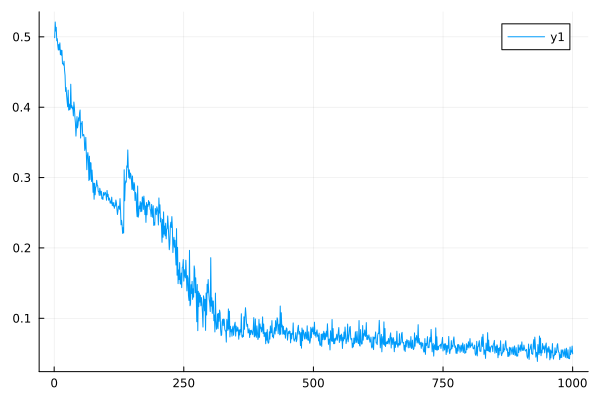

In [66]:
plot(losses_f)

In [70]:
import .PhasorNetworks: loss_and_accuracy

In [73]:
args.use_cuda

true

In [91]:
import .PhasorNetworks: predict_quadrature, accuracy_quadrature

In [100]:
function predict_quadrature(phases::AbstractMatrix)
    if on_gpu(phases)
        phases = phases |> cdev
    end

    predictions = getindex.(argmin(abs.(phases .- 0.5), dims=1), 1)'
    return predictions
end

function predict_quadrature(spikes::SpikingCall)
    phases = train_to_phase(spikes)[end-1, :, :]
    return predict_quadrature(phases)
end

function accuracy_quadrature(phases::AbstractMatrix, truth::AbstractMatrix)
    if on_gpu(phases, truth)
        phases = phases |> cdev
        truth = truth |> cdev
    end

    predictions = predict_quadrature(phases)
    labels = getindex.(findall(truth), 1)
    return predictions .== labels
end

function accuracy_quadrature(phases::Array{<:Real,3}, truth::AbstractMatrix)
    if on_gpu(phases, truth)
        phases = phases |> cdev
        truth = truth |> cdev
    end

    return [accuracy_quadrature(phases[i,:,:], truth) for i in axes(phases,1)]
end

accuracy_quadrature (generic function with 2 methods)

In [103]:
yfc = y_f |> cdev

2×256 Matrix{Float32}:
 -0.0201497   0.0457      -0.0682223    0.0168105  …   0.0145305   0.0119815
 -0.0224954  -0.00995539  -0.00617258  -0.0253506     -0.0548386  -0.0231262

In [111]:
function loss_and_accuracy(data_loader, model, ps, st, args)
    if args.use_cuda
        dev = gdev
    else
        dev = cdev
    end

    acc = 0
    ls = 0.0f0
    num = 0
    for (x, y) in data_loader
        x = x |> dev
        
        ŷ, _ = model(x, ps, st)

        if typeof(ŷ) <: SpikingTypes
            ŷ, _ = train_to_phase(ŷ)
        end
        
        ls += sum(quadrature_loss(ŷ, 1.0 .* y |> dev))
        acc += sum(accuracy_quadrature(ŷ, y)) ## Decode the output of the model
        num +=  size(y)[2]
    end
    return ls/num, acc/num
end

loss_and_accuracy (generic function with 2 methods)

In [112]:
loss_and_accuracy(test_loader, model_f, ps_train_f |> gdev, st_train_f |> gdev, args)

(0.0501451900814048, 0.98203125)

In [27]:
ps_train_f.layer_1

(bias = Float32[-0.19684447; -0.19686742;;], scale = Float32[0.81389666; 0.8042378;;])

In [28]:
yt_f, _ = model_f(x, ps_train_f, st_train_f)

([-0.06431134566450077 0.10651670865384275 … 0.5060976718095738 0.5578967142335515; 0.39281427269815455 0.4373721880071353 … 0.11791260437980783 0.024660960856190333], (layer_1 = NamedTuple(), layer_2 = NamedTuple(), layer_3 = NamedTuple(), layer_4 = NamedTuple(), layer_5 = NamedTuple()))

In [29]:
ps_train_f

(layer_1 = (bias = Float32[-0.19684447; -0.19686742;;], scale = Float32[0.81389666; 0.8042378;;]), layer_2 = NamedTuple(), layer_3 = NamedTuple(), layer_4 = (weight = Float32[0.04173581 0.011097611; 0.007310995 -0.098167986; … ; 0.15090613 -0.018089933; -0.24436979 0.022904145], bias_real = Float32[0.9893609, 1.0206473, 1.0272624, 0.9854006, 0.8565414, 0.9733166, 0.9726222, 0.98102, 0.9935856, 0.97464263  …  0.9867618, 1.0006989, 1.0331075, 1.020813, 0.98554134, 1.0059948, 0.9812722, 0.9916397, 1.0107608, 0.9958822], bias_imag = Float32[-0.0050614476, -0.0040287124, 0.0074766246, -0.014946235, 0.109835275, 0.0017270701, -0.027147572, 0.056947954, -0.00028140467, -0.010189336  …  -0.03223262, -0.036699872, -0.0041815965, 0.00930367, -0.00264803, 0.0015649532, -0.01621104, 0.02037809, 0.016045837, -0.02900312]), layer_5 = (weight = Float32[0.12459448 -0.12286748 … -0.122526824 -0.13777; -0.055697106 -0.06724836 … -0.027451849 0.09509349], bias_real = Float32[0.99746597, 0.9874371], bias_

In [30]:
yt_spk_f, _ = spk_model_f(x, ps_train_f, st_train_f)

(SpikingCall(Spike Train: (2, 256) with 5120 spikes., Neuron parameters: Period 1.0 (s)
Current kernel duration: 0.01 (s)
Threshold: 0.001 (V)
, (0.0, 10.0)), (layer_1 = NamedTuple(), layer_2 = NamedTuple(), layer_3 = NamedTuple(), layer_4 = NamedTuple(), layer_5 = NamedTuple()))

In [31]:
pt_f = train_to_phase(yt_spk_f.train, spk_args=spk_args);

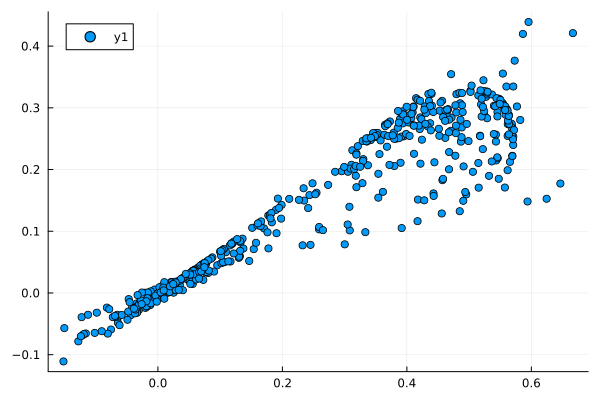

In [32]:
scatter(vec(yt_f), vec(pt_f[end-1,:,:]))

In [33]:
cycle_correlation(yt_f, pt_f)

10-element Vector{Float64}:
 0.006461719595410191
 0.7612329428711189
 0.7876563240679477
 0.8183012011102203
 0.8496381593542799
 0.8793015402733626
 0.9056243865568043
 0.9278058184415781
 0.9457683686352797
 0.6378516516150825

In [34]:
yt_spk_f.train.indices |> size

(5120,)

In [35]:
seed = Xoshiro(42)

Xoshiro(0xa379de7eeeb2a4e8, 0x953dccb6b532b3af, 0xf597b8ff8cfd652a, 0xccd7337c571680d1, 0xc90c4a0730db3f7e)

In [38]:
dropout(seed, yt_spk_f, 0.2, true, 0.8, nothing)

(SpikingCall(Spike Train: (2, 256) with 4121 spikes., Neuron parameters: Period 1.0 (s)
Current kernel duration: 0.01 (s)
Threshold: 0.001 (V)
, (0.0, 10.0)), (), Xoshiro(0xc9497a0b315534d1, 0x84c41edb3eb2fc63, 0x9f23dfd6d796c4a7, 0x0d0963d3e36f4b59, 0xc90c4a0730db3f7e))

In [39]:
dl = Chain(Dropout(0.4),)

Dropout(0.4)

In [40]:
psdr, stdr = Lux.setup(seed, dl)

(NamedTuple(), (rng = Xoshiro(0x40840703ec8883eb, 0xd2aebb06d8710c15, 0x6bdcd8b81e05f076, 0xb6e75139afa11bbb, 0xc90c4a0730db3f7e), training = Val{true}()))

In [41]:
yt_spk_f

SpikingCall(Spike Train: (2, 256) with 5120 spikes., Neuron parameters: Period 1.0 (s)
Current kernel duration: 0.01 (s)
Threshold: 0.001 (V)
, (0.0, 10.0))

In [42]:
dl(yt_spk_f, psdr, stdr)

(SpikingCall(Spike Train: (2, 256) with 3021 spikes., Neuron parameters: Period 1.0 (s)
Current kernel duration: 0.01 (s)
Threshold: 0.001 (V)
, (0.0, 10.0)), (rng = Xoshiro(0x33609a83a1f45229, 0xffc7dfad55046e0f, 0x74d3cbb94ddf3f59, 0xc5ac587b9dc31915, 0xc90c4a0730db3f7e), training = Val{true}()))

In [43]:
3021 / 5120

0.5900390625

In [36]:
dropout(yt_f)

LoadError: MethodError: no method matching dropout(::Matrix{Float64})

[0mClosest candidates are:
[0m  dropout([91m::AbstractRNG[39m, [91m::AbstractArray{T1, N}[39m, [91m::AbstractArray{T2, N}[39m, [91m::T[39m, [91m::Val[39m, [91m::Val[39m; dims, invp) where {T, T1, T2, N}
[0m[90m   @[39m [35mLuxLib[39m [90m[4mdeprecated.jl:103[24m[39m
[0m  dropout([91m::AbstractRNG[39m, [91m::AbstractArray{T1, N}[39m, [91m::AbstractArray{T2, N}[39m, [91m::T[39m, [91m::Val[39m, [91m::Val[39m, [91m::T[39m; dims) where {T, T1, T2, N}
[0m[90m   @[39m [35mLuxLib[39m [90m[4mdeprecated.jl:103[24m[39m
[0m  dropout([91m::AbstractRNG[39m, [91m::AbstractArray[39m, [91m::AbstractArray[39m, [91m::T[39m, [91m::Static.StaticBool[39m, [91m::Static.True[39m, [91m::T[39m, [91m::Any[39m) where T
[0m[90m   @[39m [35mLuxLib[39m [90m~/.julia/packages/LuxLib/vG8lL/src/api/[39m[90m[4mdropout.jl:50[24m[39m
[0m  ...
